In [ ]:
import cv2
import numpy as np
import argparse
from matplotlib import pyplot as plt
#import fprmodules.enhancement as fe
import glob
import statistics 
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from google.colab import drive
#np.seterr(divide='ignore', invalid='ignore')

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall opencv-python -y
#downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 159kB/s 
     |████████████████████████████████| 14.5MB 282kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:


In [ ]:
db = '/content/drive/My Drive/DB2_B/*.*'
dbi = (glob.glob(db))
len(dbi)

80

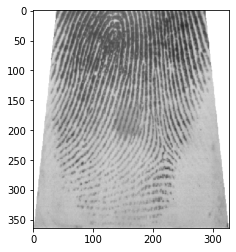

In [ ]:
image1_name = "/content/drive/My Drive/DB2_B/108_1.tif"
image2_name = "/content/drive/My Drive/DB2_B/108_4.tif"
img_1 = cv2.imread(image1_name)
img_2 = cv2.imread(image2_name)
plt.imshow(img_2)


SIFT ALGORITHM 

SIFT algorithm for feature detection is preseted. It detects and describes keypoints and features, and returns either the sum of the best matches found, or the average distance of the best matches, or the total distance of the best matches. The best matches, are declared as a percentage of the total matches.

In [ ]:
def SIFTdetector(img1,img2,case="average_distance"):
    # Initialize sift feature extractor
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    #Brute Force Matching
    #Use the metric Brute Force Matching that compares the descriptors des1, des2 
    # BFMatcher with default params in the case of SIFT
    # Distance measurement to be used is by default cv2.NORM_L2, crossCheck=False
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    #print(len(matches))
    
    # Apply ratio test
    filtered_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            filtered_matches.append([m])
    
    distance_arr=[]
    if case=='feature_sum':
        return filtered_matches
    elif case=='median_distance':
        for m in filtered_matches:
            for n in m:
                distance_arr.append(n.distance)
        if (len(distance_arr) != 0):        
            median_distance = statistics.median(distance_arr)
        else:
            median_distance = 0.0
        return median_distance;     
    elif case=='average_distance':    
        sum=0
        for m in filtered_matches:
            for n in m:
                sum+=n.distance
        if (len(filtered_matches) != 0):
            average_distance = sum /len(filtered_matches)
        else:
            average_distance = 0.0
        return average_distance;     
    
    #Draw good matches
    #img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,filtered_matches, None, flags=2)
    #plt.imshow(img3),plt.show()

DECISION FUNCTION



Subsequently, a decision function is declared. The number of matching features is taken into consideration, and four different cases are stated in order to compute the True positive, False positive, True negative, False negative matchings; the more the matches the best it is. Also, someone should notice that when a fingerprint that is compared with another fingerprint belongs to the same person should match, and in a different case should not match.

So, this function takes as argument a list of matches, a threshold, and a label with value 'true' or 'false', meaning whether two images should indeed match or not.


In [ ]:
def DecisionTotalMatches(matches, threshold, label):
    if (len(matches) >= threshold and label =='true'): # true positive case
        return "TP"
    elif (len(matches) >= threshold and label =='false'): # false positive case
        return "FP"
    elif (len(matches) < threshold and label =='true'): # false negative case
        return "FN"      
    elif (len(matches) < threshold and label =='false'): #true negative case
        return "TN"

In [ ]:
def DecisionDistanceMatches(matches, threshold, label):
    if (matches <= threshold and label =='true'): # true positive case
        return "TP"
    elif (matches <= threshold and label =='false'): # false positive case
        return "FP"
    elif (matches > threshold and label =='true'): # false negative case
        return "FN"      
    elif (matches > threshold and label =='false'): #true negative case
        return "TN" 

Compute ROC CURVE

In [ ]:
def computeROC(threshold, database, matchingFucntion, algorithm, case_=''):
    sensitivity_arr=[]
    FPR_array=[ ]
    for j in range(len(threshold)):
        TP = FP = TN = FN = 0
        for item in database:
            img1 = cv2.imread(item)
            label1= item[-9:-6]
            for obj in database:
                img2 = cv2.imread(obj)
                label2= obj[-9:-6]
                if label1==label2:
                    label='true'
                else:
                    label='false'
                if algorithm=='SIFT':                    
                    matches=SIFTdetector(img1,img2,case_)                        
                #print(len(matches))
                if matchingFucntion=='totalMatches':
                    case = (DecisionTotalMatches(matches, threshold[j], label))
                elif matchingFucntion=='distance':                    
                    case = (DecisionDistanceMatches(matches, threshold[j], label))
                if (case=='FP'):
                    FP+=1
                elif (case=='FN'):
                    FN+=1
                elif (case=='TP'):
                    TP+=1
                elif (case=='TN'):
                    TN+=1                
            
            TP-=1 #Subtract number 1, as the first comparison is between the same figerprints each time.               
        
        sensitivity = TP/(TP+FN)
        sensitivity_arr.append(sensitivity)
        false_positive_rate = FP/(FP+TN)
        FPR_array.append(false_positive_rate)

    return sensitivity_arr, FPR_array

In [ ]:
TRP_SIFT_median, FPR_SIFT_median = computeROC([40, 70, 90, 120, 130, 140, 150, 180, 220, 260], dbi, 'distance', 'SIFT', 'median_distance')

KeyboardInterrupt: ignored

In [ ]:

plt.plot(FPR_SIFT_median, TRP_SIFT_median, 'o-', color='orange', linewidth=2.0, label='SIFT-medianDistances-DB2_B')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc='lower right')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC")

NameError: ignored

Evaluate on DB2

In [ ]:
#Create a method that normalizes data between 0 and 1.
def normalization(arr):
    xmax, xmin = arr.max(), arr.min()
    normalized = (arr - xmin)/(xmax - xmin)
    return normalized

In [ ]:
def totalFeaturesArray(db, algorithm):
    arr=np.zeros((80,80))
    for i in range(len(db)):
        img1 = cv2.imread(db[i])
        for j in range(len(db)):
            img2=cv2.imread(db[j])
            arr[i,j]=len(algorithm(img1,img2,'feature_sum'))
    return arr

In [ ]:
def distancesArray(db, algorithm, case):
    arr=np.zeros((80,80)) 
    for i in range(len(db)):
        img1 = cv2.imread(db[i])
        for j in range(len(db)):
            img2=cv2.imread(db[j])
            arr[i,j] = algorithm(img1,img2,case)
    return arr

In [ ]:
#Create a matrix containing the true labels for the total matches case. 
matching_labels=np.zeros((80,80), dtype=int)

ck=0
counter=0
for i in range(0,80):
    for j in range(0+ck,8+ck):
        matching_labels[i,j] = 1
    counter+=1
    if counter==8:
        ck+=8
        counter=0
#print(matching_labels)
#print(np.shape(matching_labels))

In [ ]:
#Create a matrix containing the true labels for the total distances case. 
distance_labels=np.ones((80,80), dtype=int)

ck=0
counter=0
for i in range(0,80):
    for j in range(0+ck,8+ck):
        distance_labels[i,j] = 0
    counter+=1
    if counter==8:
        ck+=8
        counter=0
#print(distance_labels)
#print(np.shape(distance_labels))

In [ ]:
SIFT_FeatureSum_DB2_B_Initial = totalFeaturesArray(dbi, SIFTdetector)


In [ ]:
SIFT_MedianDistances_DB2_B_Initial = distancesArray(dbi, SIFTdetector, 'median_distance')

In [ ]:
SIFT_AverDistances_DB2_B_Initial = distancesArray(dbi, SIFTdetector, 'average_distance')

In [ ]:

SIFT_Features_Initial_DB2_B_normalized=normalization(SIFT_FeatureSum_DB2_B_Initial)
SIFT_MedDist_Initial_DB2_B_normalized=normalization(SIFT_MedianDistances_DB2_B_Initial)
SIFT_AverDist_Initial_DB2_B_normalized=normalization(SIFT_AverDistances_DB2_B_Initial)

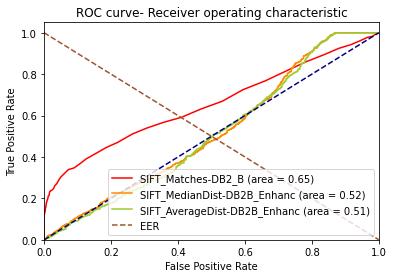

No. of Matches using SIFT: EER = 0.40901075708040313
No. of Matches using SIFT Median Distance: EER = 0.514296875
No. of Matches using SIFT Average Distance: EER = 0.5029513888888889


In [ ]:

fpr, tpr, thresholds = roc_curve(matching_labels.flatten(), SIFT_Features_Initial_DB2_B_normalized.flatten())
fpr2, tpr2, thresholds2 = roc_curve(distance_labels.flatten(), SIFT_MedDist_Initial_DB2_B_normalized.flatten())
fpr3, tpr3, thresholds3 = roc_curve(distance_labels.flatten(), SIFT_AverDist_Initial_DB2_B_normalized.flatten())

roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)


plt.figure()

plt.plot(fpr, tpr, color='red', label='SIFT_Matches-DB2_B (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='darkorange', label='SIFT_MedianDist-DB2B_Enhanc (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='yellowgreen', label='SIFT_AverageDist-DB2B_Enhanc (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case

eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer2 = brentq(lambda x : 1. - x - interp1d(fpr2, tpr2)(x), 0., 1.)
eer3 = brentq(lambda x : 1. - x - interp1d(fpr3, tpr3)(x), 0., 1.)

print('No. of Matches using SIFT: EER =', eer)
print('No. of Matches using SIFT Median Distance: EER =', eer2)
print('No. of Matches using SIFT Average Distance: EER =', eer3)
